In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras import layers
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('fight_with_stats_precomp.csv')
df_fighters = pd.read_csv('fighter_total_stats.csv')

In [4]:
df = df[(df['fightNo_fighter']>=3) & (df['fightNo_opponent']>=3) & (df['Women_fight']==0)]

In [5]:
df = df.fillna(0)


In [6]:
df.head()

,EVENT,BOUT,FIGHTER,OPPONENT,METHOD,Win,Women_fight,ROUND,HEIGHT_diff,REACH_diff,...,BODY_landed_opponent,BODY_attemps_opponent,LEG_landed_opponent,LEG_attemps_opponent,DISTANCE_landed_opponent,DISTANCE_attemps_opponent,CLINCH_landed_opponent,CLINCH_attemps_opponent,GROUND_landed_opponent,GROUND_attemps_opponent
24,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Patrick Smith,Royce Gracie,KO/TKO - ground,0,0,1,1.0,0.0,...,0.0,0.0,3.0,5.0,5.0,10.0,0.0,0.0,0.0,0.0
25,UFC 2: No Way Out,Royce Gracie vs. Patrick Smith,Royce Gracie,Patrick Smith,KO/TKO - ground,1,0,1,-1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,3.0,5.0
26,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Remco Pardoel,Royce Gracie,Submission,0,0,1,2.0,0.0,...,0.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,0.0,2.0
27,UFC 2: No Way Out,Royce Gracie vs. Remco Pardoel,Royce Gracie,Remco Pardoel,Submission,1,0,1,-2.0,0.0,...,1.0,2.0,0.0,1.0,0.0,3.0,1.0,1.0,3.0,5.0
50,UFC 4: Revenge of the Warriors,Royce Gracie vs. Dan Severn,Dan Severn,Royce Gracie,Submission,0,0,1,1.0,0.0,...,3.0,4.0,2.0,3.0,3.0,5.0,3.0,3.0,3.0,3.0


In [7]:
df.shape

(6817, 63)

In [8]:
df.columns.tolist()[19:]

['KD_fighter',
 'SUB.ATT_fighter',
 'REV._fighter',
 'CTRL_fighter',
 'SIG.STR._landed_fighter',
 'SIG.STR._attemps_fighter',
 'TOTAL STR._landed_fighter',
 'TOTAL STR._attemps_fighter',
 'TD_landed_fighter',
 'TD_attemps_fighter',
 'HEAD_landed_fighter',
 'HEAD_attemps_fighter',
 'BODY_landed_fighter',
 'BODY_attemps_fighter',
 'LEG_landed_fighter',
 'LEG_attemps_fighter',
 'DISTANCE_landed_fighter',
 'DISTANCE_attemps_fighter',
 'CLINCH_landed_fighter',
 'CLINCH_attemps_fighter',
 'GROUND_landed_fighter',
 'GROUND_attemps_fighter',
 'KD_opponent',
 'SUB.ATT_opponent',
 'REV._opponent',
 'CTRL_opponent',
 'SIG.STR._landed_opponent',
 'SIG.STR._attemps_opponent',
 'TOTAL STR._landed_opponent',
 'TOTAL STR._attemps_opponent',
 'TD_landed_opponent',
 'TD_attemps_opponent',
 'HEAD_landed_opponent',
 'HEAD_attemps_opponent',
 'BODY_landed_opponent',
 'BODY_attemps_opponent',
 'LEG_landed_opponent',
 'LEG_attemps_opponent',
 'DISTANCE_landed_opponent',
 'DISTANCE_attemps_opponent',
 'CLINCH

In [9]:
df = df.merge(df[['EVENT', 'BOUT', 'FIGHTER']+df.columns.tolist()[18:]] ,how='left', left_on=['EVENT', 'BOUT', 'OPPONENT'], right_on=['EVENT', 'BOUT', 'FIGHTER'], suffixes=('_f1', '_f2'))

In [10]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6817 entries, 0 to 6816
Data columns (total 109 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    EVENT                           6817 non-null   object 
 1    BOUT                            6817 non-null   object 
 2    FIGHTER_f1                      6817 non-null   object 
 3    OPPONENT                        6817 non-null   object 
 4    METHOD                          6817 non-null   object 
 5    Win                             6817 non-null   int64  
 6    Women_fight                     6817 non-null   int64  
 7    ROUND                           6817 non-null   int64  
 8    HEIGHT_diff                     6817 non-null   float64
 9    REACH_diff                      6817 non-null   float64
 10   AGE_diff                        6817 non-null   float64
 11   form_skore_fighter              6817 non-null   float64
 12   form_skore_opponen

In [11]:
df = df.drop('FIGHTER_f2',axis=1)

In [12]:
'LEG_attemps_fighter_f1'.split('_')

['LEG', 'attemps', 'fighter', 'f1']

In [13]:
sloupce = df.columns.tolist()[19:]

for sloupec in sloupce:    
    splited = sloupec.split('_')
    if 'CTRL' in splited:
        df.loc[:,splited[0]+'_pct_'+splited[1]+splited[2]] = df[sloupec]/df['TotalTime'+'_'+splited[2]]
    if 'attemps' in splited:
        df.loc[:,splited[0]+'_acc_'+ splited[2] + splited[3]] = df[sloupec.replace('attemps', 'landed')]/df[sloupec]
        df.loc[:,splited[0]+'_perRound_'+ splited[2] + splited[3]] = (df[sloupec.replace('attemps', 'landed')]/df['TotalTime'+'_'+splited[3]])*300
        
    

In [14]:
df = df.drop(sloupce, axis=1)

In [15]:
df_model = df.drop(['EVENT','BOUT','FIGHTER_f1','OPPONENT','METHOD','Women_fight','ROUND','TotalTime_f1'],axis=1)

In [16]:
df_model = df_model.fillna(0)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6817 entries, 0 to 6816
Data columns (total 87 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Win                             6817 non-null   int64  
 1   HEIGHT_diff                     6817 non-null   float64
 2   REACH_diff                      6817 non-null   float64
 3   AGE_diff                        6817 non-null   float64
 4   form_skore_fighter              6817 non-null   float64
 5   form_skore_opponent             6817 non-null   float64
 6   fightNo_fighter                 6817 non-null   int64  
 7   fightNo_opponent                6817 non-null   float64
 8   Win_tot                         6817 non-null   float64
 9   DRAW                            6817 non-null   float64
 10  No_contest                      6817 non-null   float64
 11  CTRL_pct_fighterf1              6817 non-null   float64
 12  SIG.STR._acc_fighterf1          68

In [17]:
X=df_model.loc[:, ~df_model.columns.isin(['Win'])]
y=df_model.loc[:,'Win']

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
y

0       0
1       1
2       0
3       1
4       0
       ..
6812    0
6813    1
6814    0
6815    0
6816    1
Name: Win, Length: 6817, dtype: int64

In [20]:
X_train = X_scaled[:1000,:]
X_test= X_scaled[1000:,:]
y_train = y[:1000]
y_test = y[1000:]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state = 0)

In [22]:
X.shape

(6817, 86)

In [23]:
y_train.shape

(5112,)

In [24]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(multi_class='ovr', max_iter=50000)
logreg.fit(X_train,y_train)
predictions = logreg.predict(X_test)
acc = accuracy_score(y_test, predictions) 
f1 = f1_score(y_test, predictions,average='micro')
print(f1, acc)

0.5888563049853373 0.5888563049853373


In [26]:
class_neur = MLPClassifier(random_state=1, max_iter=100)

In [27]:
from keras.optimizers import SGD

opt = SGD(lr=0.01)

D:\anacinda\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
model = Sequential()
model.add(layers.Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = "adam",
                loss='binary_crossentropy',
                metrics=['accuracy'])  

In [33]:
history = model.fit(X_train, y_train, epochs=100, batch_size = 32, verbose=1,validation_data=(X_test, y_test))

Epoch 1/100
160/160 [==============================] - 1s 2ms/step - loss: 0.7564 - accuracy: 0.5473 - val_loss: 0.6949 - val_accuracy: 0.5701
Epoch 2/100
160/160 [==============================] - 0s 1ms/step - loss: 0.6875 - accuracy: 0.5808 - val_loss: 0.6849 - val_accuracy: 0.5871
Epoch 3/100
160/160 [==============================] - 0s 1ms/step - loss: 0.6682 - accuracy: 0.6054 - val_loss: 0.6828 - val_accuracy: 0.5848
Epoch 4/100
160/160 [==============================] - 0s 1ms/step - loss: 0.6527 - accuracy: 0.6174 - val_loss: 0.6831 - val_accuracy: 0.5801
Epoch 5/100
160/160 [==============================] - 0s 1ms/step - loss: 0.6514 - accuracy: 0.6160 - val_loss: 0.6854 - val_accuracy: 0.5765
Epoch 6/100
160/160 [==============================] - 0s 2ms/step - loss: 0.6412 - accuracy: 0.6350 - val_loss: 0.6809 - val_accuracy: 0.5736
Epoch 7/100
160/160 [==============================] - 0s 1ms/step - loss: 0.6294 - accuracy: 0.6438 - val_loss: 0.6821 - val_accuracy: 0.5842

Epoch 58/100
160/160 [==============================] - 0s 1ms/step - loss: 0.5151 - accuracy: 0.7428 - val_loss: 0.7830 - val_accuracy: 0.5589
Epoch 59/100
160/160 [==============================] - 0s 1ms/step - loss: 0.5128 - accuracy: 0.7473 - val_loss: 0.7831 - val_accuracy: 0.5607
Epoch 60/100
160/160 [==============================] - 0s 1ms/step - loss: 0.5101 - accuracy: 0.7478 - val_loss: 0.7862 - val_accuracy: 0.5636
Epoch 61/100
160/160 [==============================] - 0s 2ms/step - loss: 0.5102 - accuracy: 0.7435 - val_loss: 0.7841 - val_accuracy: 0.5607
Epoch 62/100
160/160 [==============================] - 0s 1ms/step - loss: 0.5085 - accuracy: 0.7394 - val_loss: 0.7898 - val_accuracy: 0.5672
Epoch 63/100
160/160 [==============================] - 0s 1ms/step - loss: 0.5044 - accuracy: 0.7488 - val_loss: 0.7848 - val_accuracy: 0.5513
Epoch 64/100
160/160 [==============================] - 0s 1ms/step - loss: 0.5173 - accuracy: 0.7449 - val_loss: 0.7964 - val_accuracy:

In [117]:
test_loss, test_acc = model.evaluate(X_test, y_test)

54/54 [==============================] - 0s 848us/step - loss: 0.6870 - accuracy: 0.5736


54/54 [==============================] - 0s 698us/step


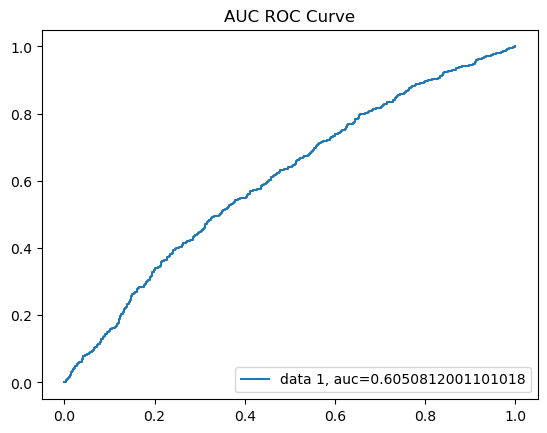

In [118]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_proba =model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("AUC ROC Curve")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {"n_estimators": randint(10, 100),
              "max_depth": randint(1, 10),
              "min_samples_split": randint(2, 10),
              "min_samples_leaf": randint(1, 10)}

# Instantiate the random forest classifier
rf = RandomForestClassifier()

# Instantiate the randomized search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=100, cv=5, random_state=42)

# Fit the randomized search on the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print(random_search.best_score_)
print(random_search.best_params_)

In [202]:
import pandas as pd
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# načtení dat

# definice lookback
lookback = 200

# převod dat na numpy array
data = df_model.values
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# rozdělení dat na trénovací a testovací
X = []
y = []
for i in range(lookback, len(data)):
    X.append(data[i-lookback:i, 1:])
    y.append(data[i, 0])
X = np.array(X)
y = np.array(y)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# vytvoření modelu
model = Sequential()
model.add(LSTM(units=100, input_shape=(lookback, data.shape[1]-1)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

# natrénování modelu na trénovacích datech
model.fit(X_train, y_train, epochs=70, batch_size=32,validation_data=(X_test, y_test))

# hodnocení modelu na testovacích datech
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


[1. 0. 1. ... 0. 0. 1.]
Epoch 1/2


ValueError: in user code:

    File "D:\anacinda\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "D:\anacinda\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\anacinda\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "D:\anacinda\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "D:\anacinda\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "D:\anacinda\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "D:\anacinda\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "D:\anacinda\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "D:\anacinda\lib\site-packages\keras\losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "D:\anacinda\lib\site-packages\keras\backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


42/42 [==============================] - 2s 38ms/step


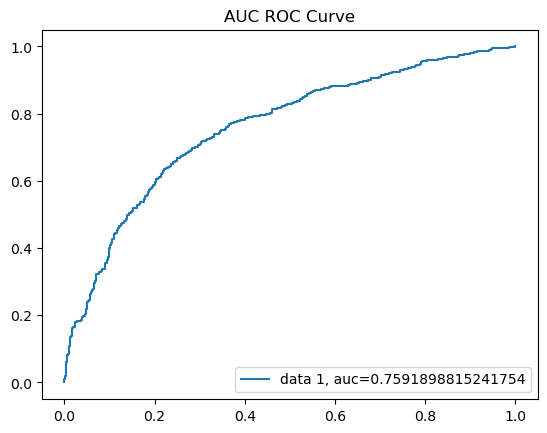

In [159]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_pred_proba =model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("AUC ROC Curve")
plt.show()

In [160]:
model.save('model.h5')

In [185]:
new_data

[array([[0.46153846, 0.5       , 0.41176471, 0.5       , 0.5       ,
         0.        , 0.02702703, 0.08695652, 0.        , 0.        ,
         0.        , 0.54166667, 0.01660952, 0.99681021, 0.78148428,
         1.        , 0.11333333, 0.        , 0.        , 0.        ,
         0.        , 0.5       , 0.08290909, 0.5       , 0.03221769,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.42857143, 0.04494444, 0.75      , 0.08823529, 1.        ,
         0.17333333, 0.5       , 0.0557931 , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.6       , 0.07428571, 0.        , 0.68611111,
         0.38175115, 0.67964332, 0.42970177, 0.        , 0.        ,
         0.65      , 0.29490114, 1.        , 0.25582048, 0.33333333,
         0.20058651, 0.3       , 0.11691903, 1.        , 0.1654649 ,
         0.75      , 0.48709677, 0.        , 0.5       , 0.1812276 ,
         0.54545455, 0.10673624, 0

In [1]:
new_data  =data[4,:]
new_data = new_data[1:]
new_data = np.reshape(new_data, (1,1,new_data.shape[0]))
new_data

NameError: name 'data' is not defined

In [200]:
y_pred = model.predict(new_data)

1/1 [==============================] - 0s 17ms/step


In [201]:
y_pred

array([[0.51924735]], dtype=float32)

In [67]:
fighter1 = "Nate Diaz"
fighter2 = "Conor McGregor"

In [42]:
df_fighters.loc[:,'pct_of_control_fighter'] = df_fighters['CTRL_fighter']/df_fighters['TotalTime']
df_fighters.loc[:,'strikes_fighter_f'] = (df_fighters['SIG.STR._landed_fighter']/df_fighters['TotalTime'])*60


In [57]:
df_fighters[['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']] = scaler.fit_transform(df_fighters[['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']])

In [68]:
f1 = df_fighters.loc[df_fighters["FIGHTER"]==fighter1 ,['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']].values.flatten().tolist()

In [69]:
f2 = df_fighters.loc[df_fighters["FIGHTER"]==fighter2 ,['form_skore_fighter','pct_of_control_fighter', 'strikes_fighter_f']].values.flatten().tolist()

In [70]:
f1+f2

[0.39875325803342343,
 -0.45128862367049577,
 0.8860974239040257,
 -0.45686035044738443,
 -0.5655206746811349,
 1.4218252543277097]

In [71]:
predikce = model.predict([f1+f2])
predikce[0][0]

1/1 [==============================] - 0s 45ms/step


0.5540724

In [72]:
print(f"{fighter1}: {round(predikce[0][0]*100,2)}%  vs {fighter2}: {round((1-predikce[0][0])*100,2)}")

Nate Diaz: 55.41%  vs Conor McGregor: 44.59


In [73]:
'McGr' in df_fighters['FIGHTER'].tolist()

False